Задание 1

Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories). Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.
В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

Необходимо проанализировать итоги эсксперимента о внедрении новой модели оплаты в приложении. Для этого рассмотрим конверсию и средний чек в контрольной и тестовой группах. С помощью конверсии увидим соотношение пользователей, которые совершили оплаты к общему числу пользователей, зашедших в приложение во время эсперимента. Средний чек покажет как и на сколько изменилась прибыль.

Проверять будем гипотезы о том, что в конторольной и тестовой группах одинаковая конверсия и средний чек. 

In [190]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [195]:
# Функцию, которая позволит проверять гипотезы с помощью бутстрапа


def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it=1000,
    statistic=np.mean,
    bootstrap_conf_level=0.95
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True
        ).values
        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values

    boot_data.append(statistic(samples_1-samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
        )
    p_value = min(p_1, p_2) * 2

    plt.hist(pd_boot_data[0], bins=50)
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

In [5]:
active_users = pd.read_csv('Проект_4_active_users.csv')
groups = groups = pd.read_csv('Проект_4_groups.csv')
purchases = pd.read_csv('Проект_4_purchases.csv')

In [6]:
active_users.head()

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male


In [7]:
active_users.isna().sum()

user_id     0
country     0
platform    0
sex         0
dtype: int64

In [8]:
active_users.nunique()

user_id     8341
country        2
platform       2
sex            2
dtype: int64

In [9]:
groups.head()

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


In [10]:
groups.isna().sum()

user_id    0
group      0
dtype: int64

In [11]:
groups.nunique()

user_id    74576
group          2
dtype: int64

In [170]:
groups.groupby('group').agg({'user_id': 'count'})

,user_id
group,
A,14693
B,59883


In [12]:
purchases.head()

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0


In [13]:
purchases.isna().sum()

user_id    0
revenue    0
dtype: int64

In [14]:
purchases.nunique()

user_id    541
revenue     98
dtype: int64

In [15]:
df = groups.merge(purchases, how='left')

In [16]:
df.revenue.sum()

578737.0

In [17]:
df

,user_id,group,revenue
0,9149,B,NaN
1,9150,B,NaN
2,9151,A,NaN
3,9152,B,NaN
4,9153,B,NaN
...,...,...,...
74571,1010,B,NaN
74572,7785,A,NaN
74573,1783,B,NaN
74574,1164,A,NaN


In [18]:
all_data = active_users.merge(df, how='left')

In [19]:
all_data.query('revenue > 0').nunique()

user_id     392
country       2
platform      2
sex           2
group         2
revenue      93
dtype: int64

Соеденив df получила 392 пользователя, которые произвели оплаты во время эксперимента, но в df о транзакциях был 541 уникальный пользователь. 

149 юзеров, которые произвели оплаты, нет в файле с информацией об активных пользователях, которые посещали приложение во время эксперимента, но они так же поделены на группы. 

In [20]:
df_1 = groups.merge(active_users, how='left')

В данной таблице учтены все пользователи, которые совершили оплаты.

In [21]:
users_purchases = df_1.merge(purchases, how ='left').query('revenue > 0')

In [22]:
users_purchases.head()

,user_id,group,country,platform,sex,revenue
60,9061,B,NaN,NaN,NaN,699.0
593,9036,B,NaN,NaN,NaN,300.0
594,9073,B,NaN,NaN,NaN,702.0
1722,9130,B,NaN,NaN,NaN,591.0
3910,9035,B,NaN,NaN,NaN,700.0


In [173]:
CR = (users_purchases.groupby(['group'])
      .agg({'user_id': 'count'}) / all_data.groupby(['group'])
                                           .agg({'user_id': 'count'}) * 100)\
                                           .round(1)

In [24]:
CR = CR.rename(columns={'user_id': 'cr'}).reset_index()

In [25]:
CR

,group,cr
0,A,7.0
1,B,6.4


Необходимо проверить есть ли значимые различия конверсии в группах.

H0: Конверсия в группах одинаковая.

Тест показал, что значимых различий конверсии в группах нет.

In [26]:
users_purchases.groupby(['group'])\
               .agg({'user_id': 'count'})

,user_id
group,
A,107
B,434


In [27]:
all_data.groupby(['group'])\
        .agg({'user_id': 'count'})

,user_id
group,
A,1538
B,6803


In [28]:
count = np.array([107, 434])
nobs = np.array([1538, 6803])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.2f}'.format(pval))

0.41


Проверка распределения на нормальность в тестовой и контрольной группах, тестом Шапиро-Вилка. 
Нулевая гипотеза теста: распределение нормальное.

Тест показал, что распределение в обеих группах ненормальное. Для проверки гипотез будем применять бутстрап

In [29]:
stats.shapiro(users_purchases.query('group == "A"').revenue)

ShapiroResult(statistic=0.7201215028762817, pvalue=5.480257090142993e-13)

In [30]:
stats.shapiro(users_purchases.query('group == "B"').revenue)

ShapiroResult(statistic=0.8677289485931396, pvalue=9.681641387832235e-19)

По 149 пользователям нет информации о стране, используемой платформе и поле. В дальнейшем при тестировании я планирую использовать данную информацию, поэтому для исследования оставлю датасет с 392 пользователями.

Но сначала посмотрим есть ли значимые различия между группами, в которые попали все платежи (541).

H0: Средний чек в контрольной и тестовой группах не различается.

Тест показал, что средний чек в группах имеет значимые различия.

In [74]:
users_purchases.groupby(['group'], as_index=False) \
               .agg({'revenue': 'mean', 'user_id': 'count'})

,group,revenue,user_id
0,A,870.672897,107
1,B,1118.836406,434


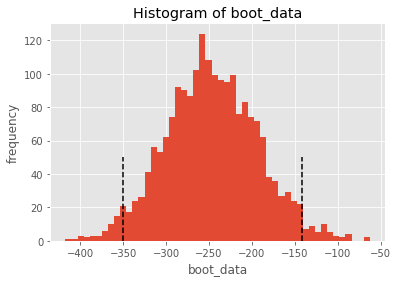

In [105]:
df_control = users_purchases.query('group == "A"')
df_test = users_purchases.query('group == "B"')
data_column_1 = df_control.revenue
data_column_2 = df_test.revenue
booted_data = get_bootstrap(data_column_1, data_column_2, boot_it=2000)

In [106]:
booted_data["p_value"]

3.8866014618581616e-06

In [107]:
booted_data["ci"]

,0
0.025,-350.231970
0.975,-141.322005


Теперь посмотрим отдельно на 149 юзеров, о которых нет информации.

In [174]:
users_no_info = users_purchases \
                    .query('country != "Russia" and country != "Sweden"')

In [109]:
users_no_info.query('country != "Russia" and country != "Sweden"')\
             .groupby(['group'], as_index=False)\
             .agg({'revenue': 'mean', 'user_id': 'count'})

,group,revenue,user_id
0,A,674.62069,29
1,B,728.85000,120


Тест Шапиро - Вилка показал, что распределение в контрольной и тестовой группах ненормальное.

In [110]:
stats.shapiro(users_no_info.query('group == "A"').revenue)

ShapiroResult(statistic=0.803894579410553, pvalue=9.817117097554728e-05)

In [111]:
stats.shapiro(users_no_info.query('group == "B"').revenue)

ShapiroResult(statistic=0.8712485432624817, pvalue=8.56404369642405e-09)

H0:  Средний чек в контрольной и тестовой группах не различается,

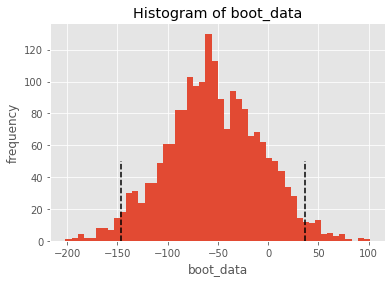

In [115]:
df_control = users_no_info.query('group == "A"')
df_test = users_no_info.query('group == "B"')
data_column_1 = df_control.revenue
data_column_2 = df_test.revenue
booted_data = get_bootstrap(data_column_1, data_column_2, boot_it=2000)

In [116]:
booted_data["p_value"]

0.250216652372656

In [117]:
booted_data["ci"]

,0
0.025,-146.650417
0.975,36.491250


Нулевую гипотезу в данном случае принять нет оснований, так как значение pvalue > 0.05 и ДИ попадает в 0, соответственно средний чек в группах на данной выборке не имеет значимых различий.


Далее возьмем только пользователей, совершивших платеж, о которых есть полная информация.

In [118]:
all_data = all_data.query('revenue > 0')

In [119]:
all_data.groupby('group').agg({'user_id': 'count'})

,user_id
group,
A,78
B,314


In [120]:
all_data.groupby(['group', 'platform', 'country'], as_index=False) \
        .agg({'revenue': 'mean', 'user_id': 'count'})

,group,platform,country,revenue,user_id
0,A,android,Russia,719.052632,19
1,A,android,Sweden,1311.800000,20
2,A,ios,Russia,906.041667,24
3,A,ios,Sweden,797.000000,15
4,B,android,Russia,1275.786408,103
5,B,android,Sweden,1164.787879,66
6,B,ios,Russia,1149.319149,94
7,B,ios,Sweden,1603.823529,51


Проверим гипотезу: H0 средний чек в группах не отличается

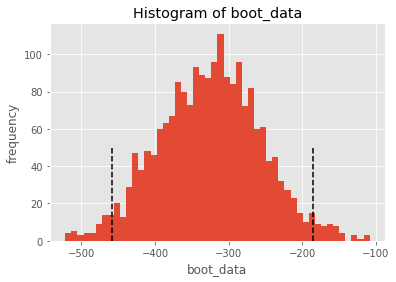

In [121]:
df_control = all_data.query('group == "A"')
df_test = all_data.query('group == "B"')
data_column_1 = df_control.revenue
data_column_2 = df_test.revenue
booted_data = get_bootstrap(data_column_1, data_column_2, boot_it=2000)

In [122]:
booted_data["p_value"]

2.3172695213292782e-06

In [123]:
booted_data["ci"]

,0
0.025,-458.704697
0.975,-185.073169


Проведя тест, выяснила, что нулевую гипотезу принять не могу, в группах есть стат. значимые различия. 

Так как в эксперименте участвуют пользователи из разных стран, а также они используют разные платформы можно посмотреть более детально, где именно есть различия.

H0: В России/Швеции в тестовой и контрольной группах нет различий.


In [124]:
all_data.groupby(['group', 'country'], as_index=False)\
        .agg({'revenue': 'mean', 'user_id': 'count'})

,group,country,revenue,user_id
0,A,Russia,823.418605,43
1,A,Sweden,1091.171429,35
2,B,Russia,1215.441624,197
3,B,Sweden,1356.162393,117


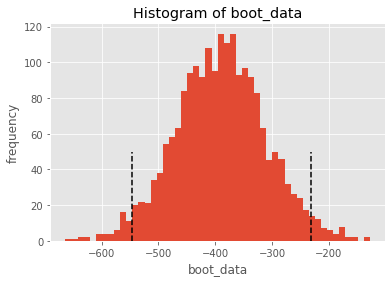

In [175]:
df_control = all_data.query('group == "A" and country == "Russia"')
df_test = all_data.query('group == "B" and country == "Russia"')
data_column_1 = df_control.revenue
data_column_2 = df_test.revenue
booted_data = get_bootstrap(data_column_1, data_column_2, boot_it=2000)

In [126]:
booted_data["p_value"]

2.0982841695158603e-07

In [127]:
booted_data["ci"]

,0
0.025,-545.158883
0.975,-240.006218


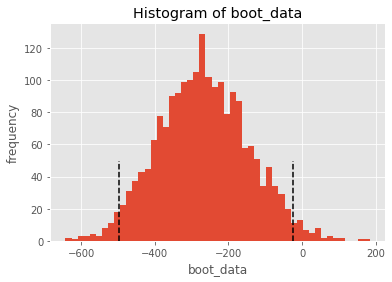

In [176]:
df_control = all_data.query('group == "A" and country == "Sweden"')
df_test = all_data.query('group == "B" and country == "Sweden"')
data_column_1 = df_control.revenue
data_column_2 = df_test.revenue
booted_data = get_bootstrap(data_column_1, data_column_2, boot_it=2000)

In [129]:
booted_data["p_value"]

0.02921481999907562

In [130]:
booted_data["ci"]

,0
0.025,-498.523718
0.975,-32.885684


Различия в группах есть. В России более значимые различия, чем в Швеции между группами. В Швеции p = 0.03, стоит посмотреть более детально.

H0: Платформы не влияют на средний чек 

In [131]:
all_data.groupby(['group', 'platform'], as_index=False)\
        .agg({'revenue': 'mean', 'user_id': 'count'})

,group,platform,revenue,user_id
0,A,android,1023.025641,39
1,A,ios,864.102564,39
2,B,android,1232.437870,169
3,B,ios,1309.179310,145


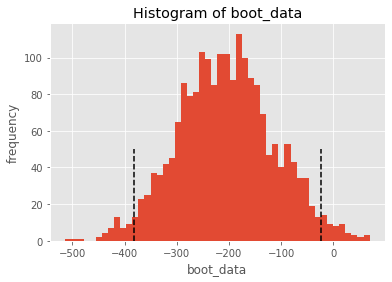

In [132]:
df_control = all_data.query('group == "A" and platform == "android"')
df_test = all_data.query('group == "B" and platform == "android"')
data_column_1 = df_control.revenue
data_column_2 = df_test.revenue
booted_data = get_bootstrap(data_column_1, data_column_2, boot_it=2000)

In [133]:
booted_data["p_value"]

0.02438551952426259

In [134]:
booted_data["ci"]

,0
0.025,-381.527663
0.975,-23.577811


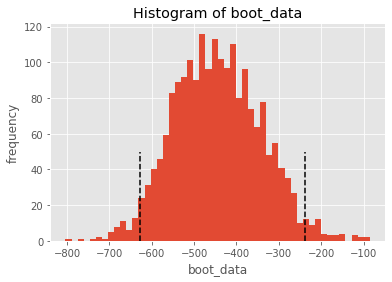

In [135]:
df_control = all_data.query('group == "A" and platform == "ios"')
df_test = all_data.query('group == "B" and platform == "ios"')
data_column_1 = df_control.revenue
data_column_2 = df_test.revenue
booted_data = get_bootstrap(data_column_1, data_column_2, boot_it=2000) 

In [136]:
booted_data["p_value"]

1.4717774773120482e-05

In [137]:
booted_data["ci"]

,0
0.025,-627.623966
0.975,-238.922069


Различия в группах есть. 

Хочу посмотреть на группы внутри стран в зависимости от используемой платформы

In [138]:
all_data.groupby(['group', 'country', 'platform'], as_index=False)\
        .agg({'revenue': 'mean', 'user_id': 'count'})

,group,country,platform,revenue,user_id
0,A,Russia,android,719.052632,19
1,A,Russia,ios,906.041667,24
2,A,Sweden,android,1311.800000,20
3,A,Sweden,ios,797.000000,15
4,B,Russia,android,1275.786408,103
5,B,Russia,ios,1149.319149,94
6,B,Sweden,android,1164.787879,66
7,B,Sweden,ios,1603.823529,51


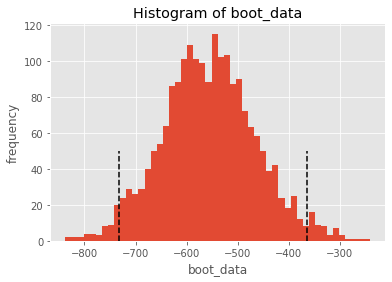

In [177]:
df_control = all_data\
    .query('group == "A" and country == "Russia" and platform == "android"')
df_test = all_data\
    .query('group == "B" and country == "Russia" and platform == "android"')
data_column_1 = df_control.revenue
data_column_2 = df_test.revenue
booted_data = get_bootstrap(data_column_1, data_column_2, boot_it=2000)

In [140]:
booted_data["p_value"]

6.588459702664796e-09

In [141]:
booted_data["ci"]

,0
0.025,-740.043447
0.975,-363.256796


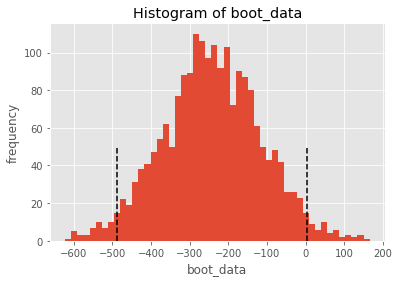

In [178]:
df_control = all_data\
       .query('group == "A" and country == "Russia" and platform == "ios"')
df_test = all_data\
       .query('group == "B" and country == "Russia" and platform == "ios"')
data_column_1 = df_control.revenue
data_column_2 = df_test.revenue
booted_data = get_bootstrap(data_column_1, data_column_2, boot_it=2000)

In [156]:
booted_data["p_value"]

0.04643276943395252

In [157]:
booted_data["ci"]

,0
0.025,-488.266489
0.975,-6.986436


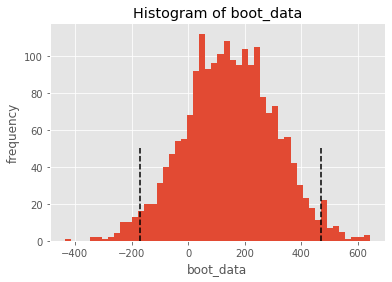

In [179]:
df_control = all_data\
    .query('group == "A" and country == "Sweden" and platform == "android"')
df_test = all_data\
    .query('group == "B" and country == "Sweden" and platform == "android"')
data_column_1 = df_control.revenue
data_column_2 = df_test.revenue
booted_data = get_bootstrap(data_column_1, data_column_2, boot_it=2000)

In [162]:
booted_data["p_value"]

0.3792539003711789

In [163]:
booted_data["ci"]

,0
0.025,-178.079545
0.975,482.168182


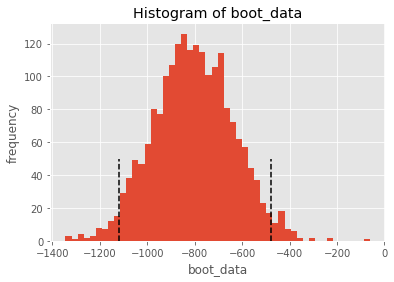

In [180]:
df_control = all_data\
     .query('group == "A" and country == "Sweden" and platform == "ios"')
df_test = all_data\
     .query('group == "B" and country == "Sweden" and platform == "ios"')
data_column_1 = df_control.revenue
data_column_2 = df_test.revenue
booted_data = get_bootstrap(data_column_1, data_column_2, boot_it=2000)

In [181]:
booted_data["p_value"]

1.5825898222422468e-06

In [182]:
booted_data["ci"]

,0
0.025,-1121.355882
0.975,-477.228922


Выводы

Конверсия в контрольной и тестовой группах не имеет стат. значимых различий (А - 7%, В - 6.4%).
Средний чек в тестовой группе вырос на +28.5% (А - 871, В - 1119). И при более детальном рассмотрении в разбивке по странам, платформам прослеживается положительная динамика роста среднего чека.

Основываясь на результат проведенного А/Б тестирования можно сказать о том, что внедрение новой модели оплаты увеличит прибыль, при сохранении конверсии.
Но учитывая, то что при более детальном рассмотрении оплат 149 пользователей выяснилось, что в данной выборке средний чек в контрольной и тестовой группе не имеет стат. значимых различий. Также разбивка пользователей по группам имеет перекос в сторону тестовой (А - 14693, В - 59883). Возможно есть проблемы в системе сплитования и это стоит проверить. Учитывая это, а также затраты на внедрение новой модели оплаты на всех пользователей, стоит провести эксперимент снова, собрав новые данные.

Ссылка на дашборд https://public.tableau.com/app/profile/victoriia5838/viz/_Dashboard_16824061209200/Dashboard?publish=yes